# Supervised Sector Classification

Let's now use the features we constructed and the known sectors to build a supervised classification model. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import gensim
import enum

In [2]:
agreements_features = pd.read_pickle("classification_features.pkl")

In [3]:
def make_np_vector(x):
    out = np.zeros(len(x))
    for i in range(len(x)):
        out[i] = x[i][1]
    return out

In [4]:
agreements_features.project_description_lsi = agreements_features.project_description_lsi.apply(make_np_vector)

In [6]:
agreements_features.project_name_lsi = agreements_features.project_name_lsi.apply(make_np_vector)

For now, let's just build a model only on the completely labeled data.

In [7]:
labeled_set = agreements_features.dropna(how='any',inplace=False,subset=['project_desc','Project Name','sector_id'])

Let's start by just using the already calculated LSI vectors as our input features. Maybe also the year?

In [8]:
desc_features = np.stack(labeled_set.project_description_lsi.to_numpy())[:,:30]
name_features = np.stack(labeled_set.project_name_lsi.to_numpy())[:,:30]
desc_distances = np.stack(labeled_set.description_similarities_lsi.to_numpy()).squeeze()
name_distances = np.stack(labeled_set.project_name_similarities_lsi.to_numpy()).squeeze()
X_features = np.concatenate([labeled_set.year.to_numpy().reshape((-1,1)),desc_features,name_features,desc_distances,name_distances],axis=1)
y = labeled_set['sector_id'].apply(int).to_numpy().ravel()

In [9]:
#Get sector names
with open("world_bank_sectors.txt") as f:
  sectors = f.read()

sectors_list = sectors.split("\n")

sector_dict = dict()
current_major_sector = ''
for sector in sectors_list:
    if sector == '':
        current_major_sector = ''
        continue
    if current_major_sector == '':
        current_major_sector = sector
        sector_dict[current_major_sector] = []
        continue
    if current_major_sector in sector_dict.keys():
        sector_dict[current_major_sector].append(sector)
sectors = list(sector_dict.keys())

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features,y,train_size=0.75,stratify=y,random_state=6247)


In [54]:
len(y_train)

511

In [12]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,train_size=0.8,stratify=y_train)

Let's build some models.

In [116]:
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


In [170]:
clf = ensemble.RandomForestClassifier(n_estimators=200,max_depth=7,class_weight="balanced",random_state=4252)
clf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=200,
                       random_state=4252)

In [171]:
y_train_pred = clf.predict(X_train)
accuracy_score(y_train,y_train_pred)

0.898238747553816

In [178]:
rf_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": [5, 6, 7, 8, None],
    "criterion": ['gini','entropy']
}
rf = GridSearchCV(estimator=clf,param_grid=rf_grid,scoring=make_scorer(accuracy_score),n_jobs=4)


In [179]:
rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=7, n_estimators=200,
                                              random_state=4252),
             n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, None],
                         'n_estimators': [100, 150, 200, 250]},
             scoring=make_scorer(accuracy_score))

In [180]:
rf.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 250}

In [181]:
rf.best_score_

0.655625356938892

In [182]:
y_test_pred = rf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.7134502923976608

In [183]:
balanced_accuracy_score(y_test,y_test_pred)

0.6131701688666499

Ok, 65% accuracy isn't too bad here, I guess.

In [156]:
top_k_accuracy_score(y_test,rf.predict_proba(X_test),k=2)

0.8070175438596491

<Figure size 720x720 with 0 Axes>

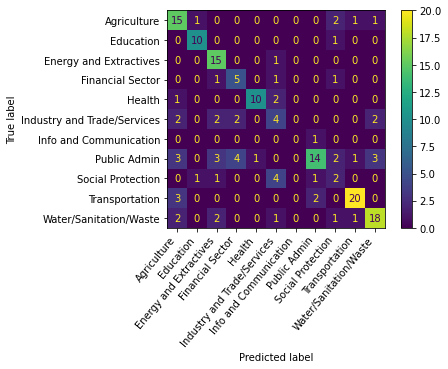

In [74]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

With the balanced class weighting, Public Admin doesn't steal all the classifications. Misclassification is much better distributed.

<Figure size 720x720 with 0 Axes>

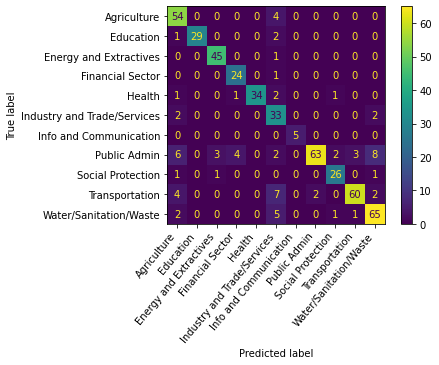

In [28]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf,X_train,y_train,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [184]:
lin = LogisticRegression(class_weight="balanced",C=1,penalty="elasticnet",l1_ratio=0.8,solver='saga',max_iter=5000, random_state=424)
logistic_grid = {
    "C": [0.1, 0.2, 0.5, 0.75, 1]
}
logistic_pipe = Pipeline([
    ('scale',StandardScaler()),
    ('logistic',GridSearchCV(estimator=lin,param_grid=logistic_grid,scoring=make_scorer(accuracy_score),n_jobs=4))
])
logistic_pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('logistic',
                 GridSearchCV(estimator=LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           l1_ratio=0.8,
                                                           max_iter=5000,
                                                           penalty='elasticnet',
                                                           random_state=424,
                                                           solver='saga'),
                              n_jobs=4,
                              param_grid={'C': [0.1, 0.2, 0.5, 0.75, 1]},
                              scoring=make_scorer(accuracy_score)))])

In [185]:
logistic_pipe['logistic'].best_params_

{'C': 0.5}

In [186]:
y_train_pred = logistic_pipe.predict(X_train)
accuracy_score(y_train,y_train_pred)

0.8140900195694716

In [187]:
y_test_pred = logistic_pipe.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.6549707602339181

<Figure size 720x720 with 0 Axes>

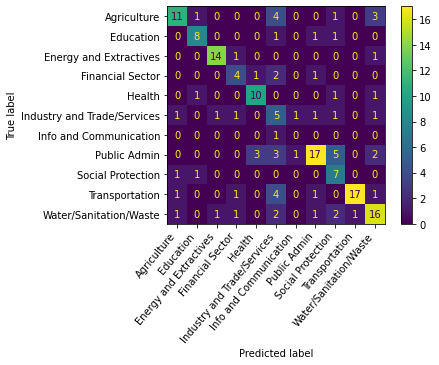

In [37]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(logistic_pipe,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [38]:
top_k_accuracy_score(y_test,logistic_pipe.predict_proba(X_test),k=2)

0.7894736842105263

In [188]:
svm = SVC(max_iter=5000,probability=True,class_weight="balanced",C=2,random_state=1212)
svm_grid = {
    "C": [0.5, 1, 2, 5]
}
pipe = Pipeline([('scale',StandardScaler()),('svm',GridSearchCV(estimator=svm,param_grid=svm_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('svm',
                 GridSearchCV(estimator=SVC(C=2, class_weight='balanced',
                                            max_iter=5000, probability=True,
                                            random_state=1212),
                              n_jobs=4, param_grid={'C': [0.5, 1, 2, 5]},
                              scoring=make_scorer(accuracy_score)))])

In [189]:
y_train_pred = pipe.predict(X_train)
accuracy_score(y_train,y_train_pred)

0.8806262230919765

In [190]:
y_test_pred = pipe.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.695906432748538

<Figure size 720x720 with 0 Axes>

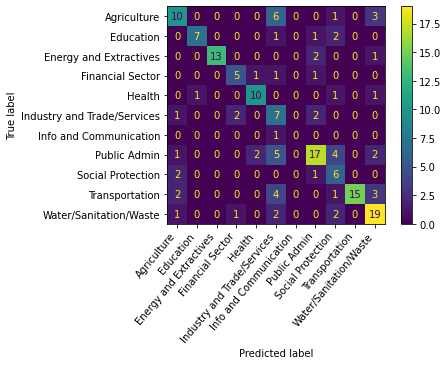

In [42]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pipe,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

<Figure size 720x720 with 0 Axes>

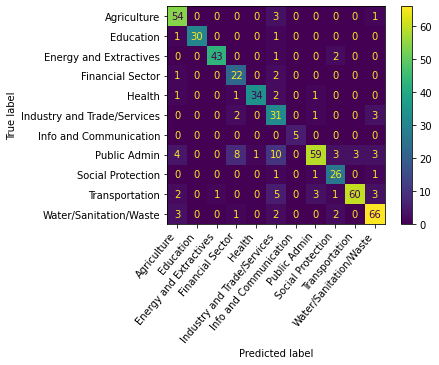

In [43]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(pipe,X_train,y_train,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [191]:
top_k_accuracy_score(y_test,pipe.predict_proba(X_test),k=2)

0.8245614035087719

In [192]:
mlp_est = MLPClassifier(hidden_layer_sizes=(32,16),max_iter=200,random_state=52234)
mlp_grid = {
    "hidden_layer_sizes": [(32, 16), (32, 32)],
    "max_iter": [200, 300, 400]
}
mlp = Pipeline([('scale', StandardScaler()),('mlp',GridSearchCV(estimator=mlp_est,param_grid=mlp_grid,scoring=make_scorer(accuracy_score),n_jobs=4))])
mlp.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scale', StandardScaler()),
                ('mlp',
                 GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(32,
                                                                          16),
                                                      random_state=52234),
                              n_jobs=4,
                              param_grid={'hidden_layer_sizes': [(32, 16),
                                                                 (32, 32)],
                                          'max_iter': [200, 300, 400]},
                              scoring=make_scorer(accuracy_score)))])

In [193]:
mlp['mlp'].best_params_

{'hidden_layer_sizes': (32, 16), 'max_iter': 300}

In [194]:
accuracy_score(y_test,mlp.predict(X_test))

0.672514619883041

In [195]:
top_k_accuracy_score(y_test,mlp.predict_proba(X_test),k=2)

0.7953216374269005

In [203]:
ens = VotingClassifier([
    ('rf',rf),
    ('logistic',logistic_pipe),
    ('svm',pipe),
    ('mlp',mlp)
],voting='soft',weights=[0.6,0.1,0.1,0.2])
ens.fit(X_train,y_train)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                                            max_depth=7,
                                                                            n_estimators=200,
                                                                            random_state=4252),
                                           n_jobs=4,
                                           param_grid={'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [5, 6, 7, 8,
                                                                     None],
                                                       'n_estimators': [100,
                                                                        150,
                                                              

In [204]:
y_train_pred = ens.predict(X_train)
accuracy_score(y_train,y_train_pred)

0.9960861056751468

In [205]:
y_test_pred = ens.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.7251461988304093

In [206]:
balanced_accuracy_score(y_test,y_test_pred)

0.6358501949337726

In [207]:
top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=2)

0.8421052631578947

In [208]:
top_k_accuracy_score(y_test,ens.predict_proba(X_test),k=5)

0.9532163742690059

<Figure size 720x720 with 0 Axes>

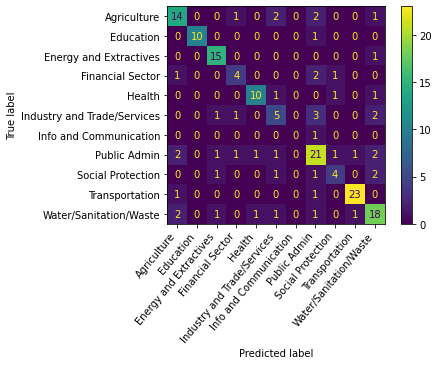

In [210]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(ens,X_test,y_test,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

The ensemble model does slightly better than the random forest alone. So I guess we do that?

In [211]:
ens.fit(X_features,y)

/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jakobhansen/.pyenv/versions/miniforge3-4.9.2/envs/erdos/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                                            max_depth=7,
                                                                            n_estimators=200,
                                                                            random_state=4252),
                                           n_jobs=4,
                                           param_grid={'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [5, 6, 7, 8,
                                                                     None],
                                                       'n_estimators': [100,
                                                                        150,
                                                              

In [212]:
y_pred = ens.predict(X_features)
accuracy_score(y,y_pred)

0.9780058651026393

<Figure size 720x720 with 0 Axes>

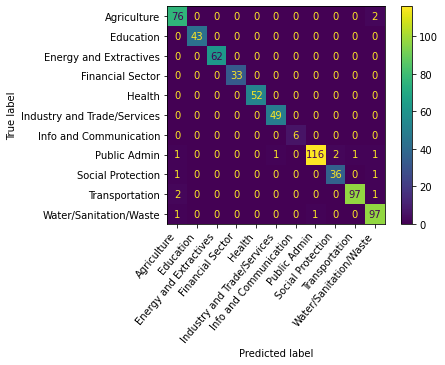

In [213]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(ens,X_features,y,display_labels=sectors)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

In [214]:
top_k_accuracy_score(y,ens.predict_proba(X_features),k=2)

0.998533724340176

In [232]:
good_features = agreements_features.dropna(how='any',inplace=False,subset=['project_desc','Project Name'])
good_features = good_features.loc[good_features.project_name_lsi.apply(len) != 0]

In [233]:
good_features.describe()

,Unnamed: 0,year,day,id_x,sector_id,description_topic_predictions,project_name_topic_predictions,description_topic_predictions_doc2vec,project_name_topic_predictions_doc2vec,predictions_doc2vec
count,2833.000000,2833.000000,2833.000000,2.833000e+03,682.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000
mean,1598.098129,2003.698553,16.078715,5.387686e+17,5.576246,5.279209,5.555242,5.262972,6.870102,5.507236
std,922.836168,8.918585,8.645879,2.556363e+17,3.441249,2.850324,3.001154,3.063539,0.714607,3.012691
min,0.000000,1990.000000,1.000000,1.002615e+17,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,801.000000,1995.000000,9.000000,3.178015e+17,2.000000,4.000000,3.000000,3.000000,7.000000,3.000000
50%,1601.000000,2004.000000,16.000000,5.285615e+17,7.000000,5.000000,6.000000,6.000000,7.000000,7.000000
75%,2390.000000,2011.000000,23.000000,7.576915e+17,9.000000,7.000000,8.000000,8.000000,7.000000,8.000000
max,3198.000000,2019.000000,31.000000,9.997015e+17,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [235]:
good_features.project_name_lsi.apply(len).describe()

count    2833.0
mean      300.0
std         0.0
min       300.0
25%       300.0
50%       300.0
75%       300.0
max       300.0
Name: project_name_lsi, dtype: float64

In [236]:
desc_features = np.stack(good_features.project_description_lsi.to_numpy())[:,:30]
name_features = np.stack(good_features.project_name_lsi.to_numpy())[:,:30]
desc_distances = np.stack(good_features.description_similarities_lsi.to_numpy()).squeeze()
name_distances = np.stack(good_features.project_name_similarities_lsi.to_numpy()).squeeze()
X_in = np.concatenate([good_features.year.to_numpy().reshape((-1,1)),desc_features,name_features,desc_distances,name_distances],axis=1)

good_features['supervised_predictions'] = ens.predict(X_in)

In [237]:
good_features['predicted_sector'] = good_features.supervised_predictions.apply(lambda x: sectors[x])

In [241]:
sector_counts = good_features.predicted_sector.value_counts()

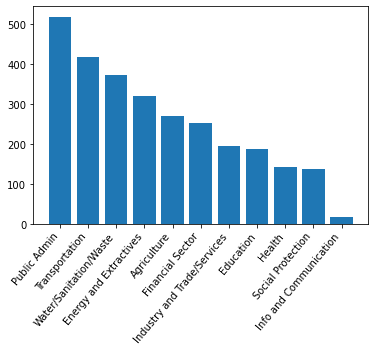

In [243]:
plt.plot(figsize=(8,8))
plt.bar(sector_counts.index, sector_counts.values)
plt.xticks(rotation=50,fontsize=10,position=(1,0),horizontalalignment='right')
plt.show()

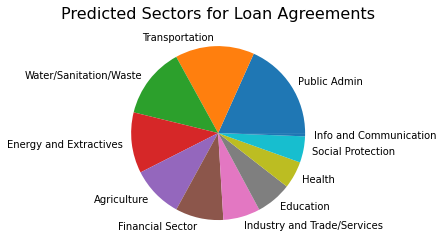

In [249]:
plt.plot(figsize=(12,12))
plt.pie(sector_counts.values,labels=sector_counts.index)
plt.title("Predicted Sectors for Loan Agreements",fontsize=16)
plt.show()

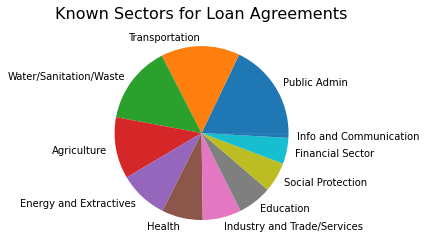

In [250]:
validated_sector_counts = labeled_set.major_sector_name.value_counts()
plt.plot(figsize=(12,12))
plt.pie(validated_sector_counts.values,labels=validated_sector_counts.index)
plt.title("Known Sectors for Loan Agreements",fontsize=16)
plt.show()

In [251]:
good_features.columns

Index(['Unnamed: 0', 'year', 'month', 'day', 'id_x', 'name', 'project_desc',
       'top_common_40', 'Project Name', 'wb_project_id', 'id_y',
       'major_sector_name', 'sector_id', 'project_description_tfidf',
       'project_name_tfidf', 'description_topic_predictions',
       'project_name_topic_predictions',
       'description_topic_predictions_doc2vec',
       'project_name_topic_predictions_doc2vec', 'predictions_doc2vec',
       'project_description_lsi', 'project_name_lsi',
       'description_similarities_lsi', 'project_name_similarities_lsi',
       'supervised_predictions', 'predicted_sector'],
      dtype='object')

In [254]:
good_features.drop('project_desc',axis=1,inplace=True)

In [255]:
good_features.to_pickle('predicted_sectors.pkl')